In [2]:
from datetime import datetime
from operator import add
from pyspark import SparkContext, SparkConf
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.sql import *
from pyspark.sql.functions import avg, format_number, round
from pyspark.sql.types import *
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import numpy as np
import re
import time

start_time = time.time()
conf = SparkConf()

# conf.setMaster("spark://192.168.2.173:7077") \
#         .setAppName("olle-wk-analysis")\
#         .set("spark.dynamicAllocation.enabled", True)\
#         .set("spark.shuffle.service.enabled", True)\
#         .set("spark.dynamicAllocation.executorIdleTimeout","30s")\
#         .set("spark.executor.cores",2)\
#         .set("spark.cores.max",8)\
#         .set("spark.driver.port",9998)\
#         .set("spark.blockManager.port",10005)

# context = SparkContext(conf=conf)
# context.getOrCreate()
sc

<SparkContext master=local[*] appName=PySparkShell>

In [14]:
filepath_mt = "/Users/zhengxin/Desktop/data/mean_temp_preprocessed/*.txt"
filepath_mint = "/Users/zhengxin/Desktop/data/min_temp_preprocessed/*.txt"
filepath_maxt = "/Users/zhengxin/Desktop/data/max_temp_preprocessed/*.txt"
filepath_tg = "/Users/zhengxin/Desktop/data/station_tg.txt"
filepath_tx = "/Users/zhengxin/Desktop/data/station_tx.txt"
filepath_tn = "/Users/zhengxin/Desktop/data/station_tn.txt"

### 1. Preprocess the mean temperature and weather stations data

In [4]:
# Note! The text files used for this application is 
# preprocessed using the Python script 'preprocess-txt.py'.
# It simply removes the first 20 lines for each text file.

In [17]:
spark = SparkSession(sc)

# Load all the weather stations as a Spark dataframe
df_tx0 = spark.read.format("csv")\
                                .option("header", "true")\
                                .load(filepath_tx)
df_tx1 = df_tx0.select([F.col(col).alias(col.strip()) for col in df_tx0.columns]).drop("STANAME", "LAT", "LON", "HGHT")

# Load all the max temperature data as a Spark dataframe
df_maxt0 = spark.read.format("csv")\
                                .option("header", "true")\
                                .load(filepath_maxt)
df_maxt1 = df_maxt0.select([F.col(col).alias(col.strip()) for col in df_maxt0.columns]).drop("SOUID", "Q_TG")

# Fetch the header names of both dataframes
header_tx = df_tx1.schema.names
header_maxt = df_maxt1.schema.names

In [18]:

# Load all the weather stations as a Spark dataframe
df_st0 = spark.read.format("csv")\
                                .option("header", "true")\
                                .load(filepath_tn)
df_st1 = df_st0.select([F.col(col).alias(col.strip()) for col in df_st0.columns]).drop("STANAME", "LAT", "LON", "HGHT")

# Load all the min temperature data as a Spark dataframe
df_mt0 = spark.read.format("csv")\
                                .option("header", "true")\
                                .load(filepath_mint)
df_mt1 = df_mt0.select([F.col(col).alias(col.strip()) for col in df_mt0.columns]).drop("SOUID", "Q_TG")

# Fetch the header names of both dataframes
header_mt = df_mt1.schema.names
header_st = df_st1.schema.names

In [19]:
# Define how many times the dataframes are supposed
# to be replicated for the scalability analysis

# df_mt1_un1 = df_mt1.union(df_mt1)
# df_mt1_un2 = df_mt1_un1.union(df_mt1)
# df_mt1_un3 = df_mt1_un2.union(df_mt1)
df_mt1_final = df_mt1
df_maxt1_final = df_maxt1

In [21]:
# Convert null values, typed as "-9999", as None in the dataframe.
df_mt2_final = df_mt1_final.withColumn("TN", 
                         when(col('TN') == -9999, None)\
                        .otherwise(col('TN')))

# Multiply every data point (mean temperature) with 0.1,
# since each value is mutliplied with a factor 10 in 
# the original text files.
df_mt2_final = df_mt2_final\
                         .withColumn("TN", format_number(0.1*(df_mt2_final['TN']), 2)\
                         .cast(DoubleType()))    

# Convert the weather station IDs to integers.
df_mt2_final = df_mt2_final\
                         .withColumn("STAID", df_mt2_final['STAID']\
                         .cast(IntegerType()))

df_st2 = df_st1\
                 .withColumn("STAID", df_st1['STAID']\
                 .cast(IntegerType()))

In [22]:
# Convert null values, typed as "-9999", as None in the dataframe.
df_maxt2_final = df_maxt1_final.withColumn("TX", 
                         when(col('TX') == -9999, None)\
                        .otherwise(col('TX')))

# Multiply every data point (mean temperature) with 0.1,
# since each value is mutliplied with a factor 10 in 
# the original text files.
df_maxt2_final = df_maxt2_final\
                         .withColumn("TX", format_number(0.1*(df_maxt2_final['TX']), 2)\
                         .cast(DoubleType()))    

# Convert the weather station IDs to integers.
df_maxt2_final = df_maxt2_final\
                         .withColumn("STAID", df_maxt2_final['STAID']\
                         .cast(IntegerType()))

df_tx2 = df_tx1\
                 .withColumn("STAID", df_tx1['STAID']\
                 .cast(IntegerType()))

In [23]:
print("The schema of the mean temperature dataframe:")
df_mt2_final.printSchema()

print("The column names and their data types:")
for col_name, dtype in df_mt2_final.dtypes:
    print(f" • {col_name} {dtype}")
    
print(("\nPS. The date is kept as a string type, since it\n")+
      ("was easier run queries to find duplicates of the ")+
      ("same dates."))

The schema of the mean temperature dataframe:
root
 |-- STAID: integer (nullable = true)
 |-- DATE: string (nullable = true)
 |-- TN: double (nullable = true)
 |-- Q_TN: string (nullable = true)

The column names and their data types:
 • STAID int
 • DATE string
 • TN double
 • Q_TN string

PS. The date is kept as a string type, since it
was easier run queries to find duplicates of the same dates.


In [24]:
print("The schema of the stations dataframe:")
df_st2.printSchema()

print("The column names and their data types:")
for col_name, dtype in df_st2.dtypes:
    print(f" • {col_name} {dtype}")

The schema of the stations dataframe:
root
 |-- STAID: integer (nullable = true)
 |-- CN: string (nullable = true)

The column names and their data types:
 • STAID int
 • CN string


In [27]:
# Add the country label for each weather station in the
# mean temperature dataframe
df_mt3_final = df_mt2_final.alias("mt")\
                           .join(df_st2.alias("st"), 
                            on = col("mt.STAID") == col("st.STAID"),
                            how = "inner")\
                           .select(col("mt.DATE"), col("st.CN"), col("mt.TN"))
df_maxt3_final = df_maxt2_final.alias("mt")\
                           .join(df_tx2.alias("st"), 
                            on = col("mt.STAID") == col("st.STAID"),
                            how = "inner")\
                           .select(col("mt.DATE"), col("st.CN"), col("mt.TX"))

In [28]:
# This cell will remove all the duplicates

# Take the mean temperature (of the mean temperature) for all
# weather stations in each country each day.
df_mt4_final = df_mt3_final.groupBy(col("DATE"), col("CN"))\
                                        .agg(format_number(F.mean('TN'),2)\
                                        .alias("TN_mean"))
print(df_mt4_final.head(5))
df_maxt4_final = df_maxt3_final.groupBy(col("DATE"), col("CN"))\
                                        .agg(format_number(F.mean('TX'),2)\
                                        .alias("TX_mean"))
print(df_maxt4_final.head(5))

[Row(DATE='17631111', CN='IT', TN_mean='8.60'), Row(DATE='17640222', CN='IT', TN_mean='5.30'), Row(DATE='17650416', CN='IT', TN_mean='7.90'), Row(DATE='17650504', CN='IT', TN_mean='11.00'), Row(DATE='17660609', CN='IT', TN_mean='20.50')]
[Row(DATE='17631111', CN='IT', TX_mean='11.20'), Row(DATE='17640222', CN='IT', TX_mean='10.90'), Row(DATE='17650416', CN='IT', TX_mean='14.70'), Row(DATE='17650504', CN='IT', TX_mean='14.20'), Row(DATE='17660609', CN='IT', TX_mean='27.50')]


### 2. Time series analysis of the data

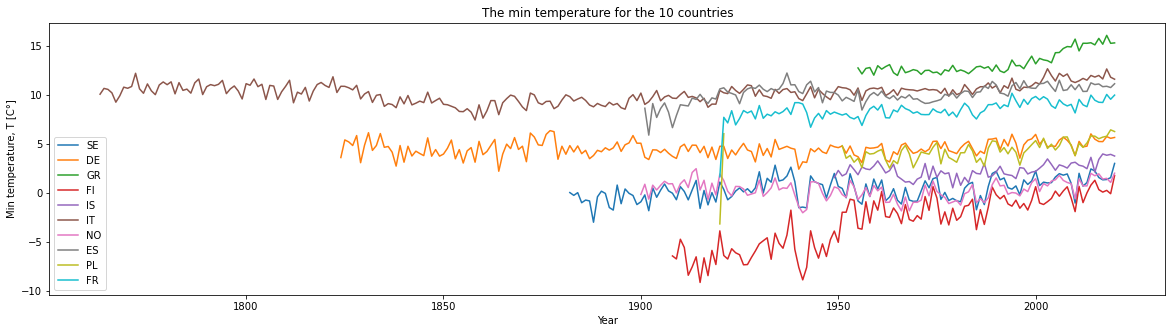

In [39]:
# The chosen countries are: Sweden, Germany, Greece, Finland, Iceland
# Italy, Norway, Spain, Poland and France.
countries= ['SE', 'DE', 'GR', 'FI','IS', 'IT', 'NO', 'ES', 'PL','FR']

# Define the figure
plt.rcParams["figure.figsize"] = (20,5)
plt.figure()

for i in range(len(countries)):
    # Fetch the country
    df0= df_mt4_final.select("*").distinct().where(col("CN") == countries[i])
    
    # Convert the dates to years and add it as a column in the dataframe
    df1= df0.withColumn("year", df0.DATE.substr(1,4))
    
    # Transform the Pandas dataframe to a Spark dataframe
    df2 = df1.select(*['DATE', 'TN_mean', 'CN', 'year']).toPandas() 
    
    # Define the data types for each column
    df3 = df2.astype({'DATE' : 'datetime64', 'CN' : 'string', 'TN_mean' : 'float64', 'year' : 'int64'})
    
    # Take the moving average of the (mean temperature) for each year
    df4 = df3.groupby(['year'],as_index=False).mean('TN_mean')
    
    # Remove the current year
    df5 = df4[df4.year != 2021]

    # Visualize the moving average of the mean temperature for all
    # the countries
    plt.plot(df5['year'], df5['TN_mean'], label = i)
    plt.xlabel("Year")
    plt.ylabel("Min temperature, T̅ [C°]")
plt.legend(countries)
plt.title("The min temperature for the 10 countries")
plt.show()

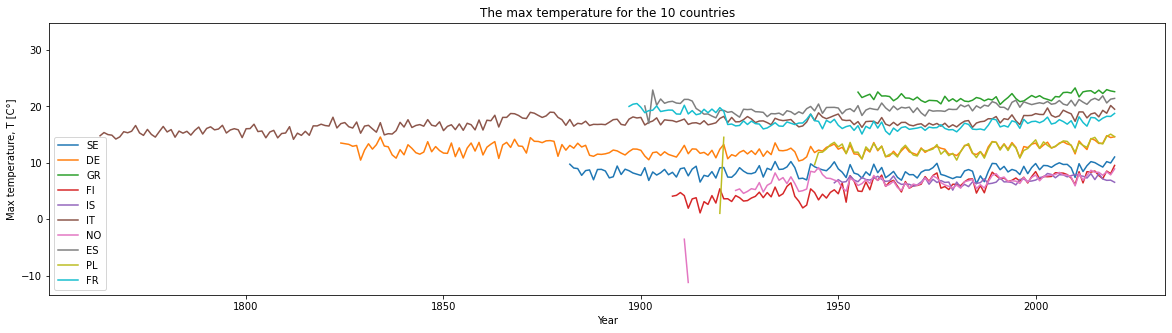

In [40]:
# The chosen countries are: Sweden, Germany, Greece, Finland, Iceland
# Italy, Norway, Spain, Poland and France.
countries= ['SE', 'DE', 'GR', 'FI','IS', 'IT', 'NO', 'ES', 'PL','FR']

# Define the figure
plt.rcParams["figure.figsize"] = (20,5)
plt.figure()

for i in range(len(countries)):
    # Fetch the country
    df0= df_maxt4_final.select("*").distinct().where(col("CN") == countries[i])
    
    # Convert the dates to years and add it as a column in the dataframe
    df1= df0.withColumn("year", df0.DATE.substr(1,4))
    
    # Transform the Pandas dataframe to a Spark dataframe
    df2 = df1.select(*['DATE', 'TX_mean', 'CN', 'year']).toPandas() 
    
    # Define the data types for each column
    df3 = df2.astype({'DATE' : 'datetime64', 'CN' : 'string', 'TX_mean' : 'float64', 'year' : 'int64'})
    
    # Take the moving average of the (mean temperature) for each year
    df4 = df3.groupby(['year'],as_index=False).mean('TX_mean')
    
    # Remove the current year
    df5 = df4[df4.year != 2021]

    # Visualize the moving average of the mean temperature for all
    # the countries
    plt.plot(df5['year'], df5['TX_mean'], label = i)
    plt.xlabel("Year")
    plt.ylabel("Max temperature, T̅ [C°]")
plt.legend(countries)
plt.title("The max temperature for the 10 countries")
plt.show()

In [121]:
# The chosen countries are: Sweden, Germany, Greece, Finland, Iceland
# Italy, Norway, Spain, Poland and France.
countries= ['SE', 'DE', 'GR', 'FI','IS', 'IT', 'NO', 'ES', 'PL','FR']

# for i in range(len(countries)):
    # Fetch the country
df0= df_mt4_final.select("*").distinct().where(col("CN") == 'DE')
    
    # Convert the dates to years and add it as a column in the dataframe
df1= df0.withColumn("year", df0.DATE.substr(1,4))
    
    # Transform the Pandas dataframe to a Spark dataframe
df2 = df1.select(*['DATE', 'TN_mean', 'CN', 'year']).toPandas() 
    
    # Define the data types for each column
df3 = df2.astype({'DATE' : 'datetime64', 'CN' : 'string', 'TN_mean' : 'float64', 'year' : 'int64'})
    
    # Take the moving average of the (mean temperature) for each year
df4 = df3.groupby(['year'],as_index=False).mean('TN_mean')
    
    # Remove the current year
df5 = df4[df4.year != 2021]
    
print(df5.head(5))

# for i in range(len(countries)):
    # Fetch the country
dfmax0= df_maxt4_final.select("*").distinct().where(col("CN") == 'DE')
    
    # Convert the dates to years and add it as a column in the dataframe
dfmax1= dfmax0.withColumn("year", dfmax0.DATE.substr(1,4))
    
    # Transform the Pandas dataframe to a Spark dataframe
dfmax2 = dfmax1.select(*['DATE', 'TX_mean', 'CN', 'year']).toPandas() 
    
    # Define the data types for each column
dfmax3 = dfmax2.astype({'DATE' : 'datetime64', 'CN' : 'string', 'TX_mean' : 'float64', 'year' : 'int64'})
    
    # Take the moving average of the (mean temperature) for each year
dfmax4 = dfmax3.groupby(['year'],as_index=False).mean('TX_mean')
    
    # Remove the current year
dfmax5 = dfmax4[dfmax4.year != 2021]
    
print(dfmax5.head())

   year  TN_mean
0  1781      NaN
1  1782      NaN
2  1783      NaN
3  1784      NaN
4  1785      NaN
    year    TX_mean
0   1781        NaN
1   1782        NaN
2   1783        NaN
3   1784        NaN
4   1785        NaN
..   ...        ...
95  1876  13.887705
96  1877  13.932301
97  1878  13.803973
98  1879  11.144027
99  1880  13.224891

[100 rows x 2 columns]


In [126]:
import pandas as pd
merge = pd.merge(df5, dfmax5, on = 'year')
print(pd.concat([df5, dfmax5], axis=1, keys = 'year'))
print(merge)

        y               e           
     year   TN_mean  year    TX_mean
0    1781       NaN  1781        NaN
1    1782       NaN  1782        NaN
2    1783       NaN  1783        NaN
3    1784       NaN  1784        NaN
4    1785       NaN  1785        NaN
..    ...       ...   ...        ...
235  2016  5.229836  2016  13.425902
236  2017  5.219644  2017  13.461781
237  2018  5.731753  2018  14.801096
238  2019  5.558164  2019  14.472329
239  2020  5.645355  2020  14.610765

[240 rows x 4 columns]
     year   TN_mean    TX_mean
0    1781       NaN        NaN
1    1782       NaN        NaN
2    1783       NaN        NaN
3    1784       NaN        NaN
4    1785       NaN        NaN
..    ...       ...        ...
235  2016  5.229836  13.425902
236  2017  5.219644  13.461781
237  2018  5.731753  14.801096
238  2019  5.558164  14.472329
239  2020  5.645355  14.610765

[240 rows x 3 columns]


In [117]:
gdp = pd.read_excel("/Users/zhengxin/Desktop/data/gdp.xlsx")
gdp_mean = gdp.groupby(gdp.index // 4).agg({'year':'last', 'Germany':'mean'})
gdp_mean['year'] = gdp_mean['year'].apply(lambda x:x[:4]).tolist() 
print(gdp_mean.head())

   year  Germany
0  1996   88.025
1  1997   89.700
2  1998   90.275
3  1999   90.350
4  2000   91.200


In [120]:
GDP = pd.concat([merge, gdp_mean],join="outer")

    year  TX_mean_x  TX_mean_y  Germany
0   1880        NaN  13.224891      NaN
1   1881        NaN  12.233534      NaN
2   1882        NaN  13.079836      NaN
3   1883        NaN  12.580685      NaN
4   1884        NaN  13.467541      NaN
5   1885        NaN  12.798986      NaN
6   1886        NaN  13.097890      NaN
7   1887        NaN  11.326658      NaN
8   1888        NaN  11.145792      NaN
9   1889        NaN  11.533151      NaN
10  1890        NaN  11.483205      NaN
11  1891        NaN  11.587342      NaN
12  1892        NaN  11.780109      NaN
13  1893        NaN  12.258932      NaN
14  1894        NaN  12.104247      NaN
15  1895        NaN  11.715479      NaN
16  1896        NaN  11.382760      NaN
17  1897  19.995068  11.983863      NaN
18  1898  20.386849  12.440438      NaN
19  1899  20.505479  12.420685      NaN


### Stop the application

In [12]:
sc.stop()

In [13]:
end_time = time.time()
print(f"It took {np.round(end_time - start_time, 1)} seconds to finish the app")

It took 429.2 seconds to finish the app
